In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [11]:
 # Get a list of column names and types of measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
 # Get a list of column names and types of station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Latest Date Check
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
# Since the latest available date in dataset is '2017-08-23', last 12 months would be from '2016-08-23' to '2017-08-23'.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
session_query = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date > query_date).\
                    order_by(Measurement.date).all()
session_query

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.35),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.02),
 ('2016-08-30', 0.0),
 ('2016-08-30', 0.0),
 (

<IPython.core.display.Javascript object>


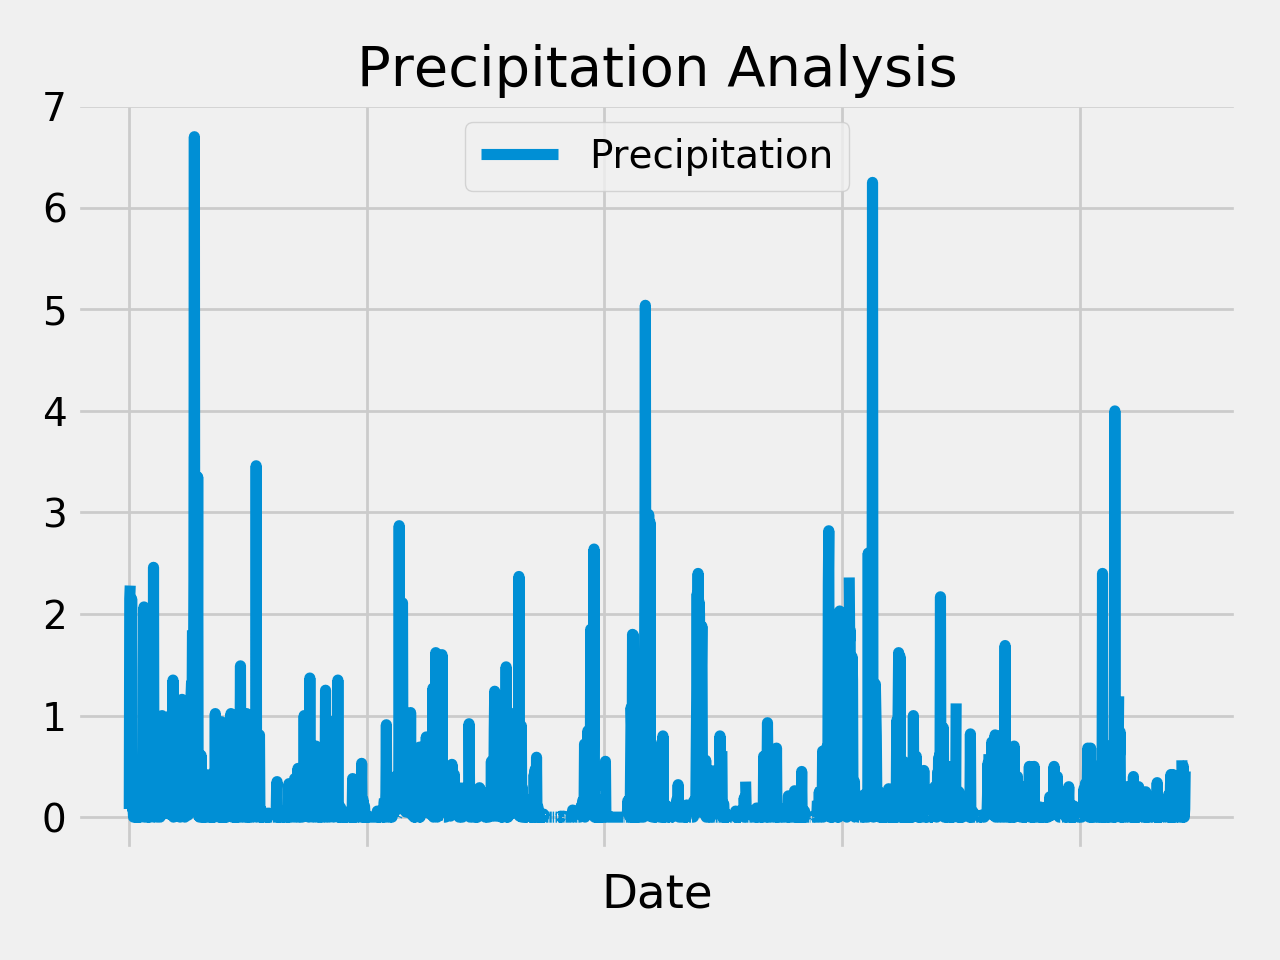

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
DF = pd.DataFrame(session_query)
DF.set_index('date')

# Sort the dataframe by date
DF.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
DF.plot('date', 'prcp')
plt.xlabel('Date')
plt.title('Precipitation Analysis')
plt.legend(['Precipitation'])
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
DF.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [17]:
# How many stations are available in this dataset?
session.query(Station.id).count()

9

In [18]:
# What are the most active stations?
# List the stations and the counts in descending order.
# tobs = Temperature Observation Data
session.query(Measurement.station, func.count(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Most active station is 'USC00519281'
min_temp = session.query(func.min(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

max_temp = session.query(func.max(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

avg_temp = session.query(func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

min_temp, max_temp, avg_temp

([(54.0)], [(85.0)], [(71.66378066378067)])

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_19281 = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date > query_date).\
                    order_by(Measurement.date).all()
tobs_19281

[('USC00519281', '2016-08-24', 77.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-26', 80.0),
 ('USC00519281', '2016-08-27', 75.0),
 ('USC00519281', '2016-08-28', 73.0),
 ('USC00519281', '2016-08-29', 78.0),
 ('USC00519281', '2016-08-30', 77.0),
 ('USC00519281', '2016-08-31', 78.0),
 ('USC00519281', '2016-09-01', 80.0),
 ('USC00519281', '2016-09-02', 80.0),
 ('USC00519281', '2016-09-03', 78.0),
 ('USC00519281', '2016-09-04', 78.0),
 ('USC00519281', '2016-09-05', 78.0),
 ('USC00519281', '2016-09-06', 73.0),
 ('USC00519281', '2016-09-07', 74.0),
 ('USC00519281', '2016-09-08', 80.0),
 ('USC00519281', '2016-09-09', 79.0),
 ('USC00519281', '2016-09-10', 77.0),
 ('USC00519281', '2016-09-11', 80.0),
 ('USC00519281', '2016-09-12', 76.0),
 ('USC00519281', '2016-09-13', 79.0),
 ('USC00519281', '2016-09-14', 75.0),
 ('USC00519281', '2016-09-15', 79.0),
 ('USC00519281', '2016-09-16', 78.0),
 ('USC00519281', '2016-09-17', 79.0),
 ('USC00519281', '2016-09-18', 78.0),
 ('USC005192

<IPython.core.display.Javascript object>


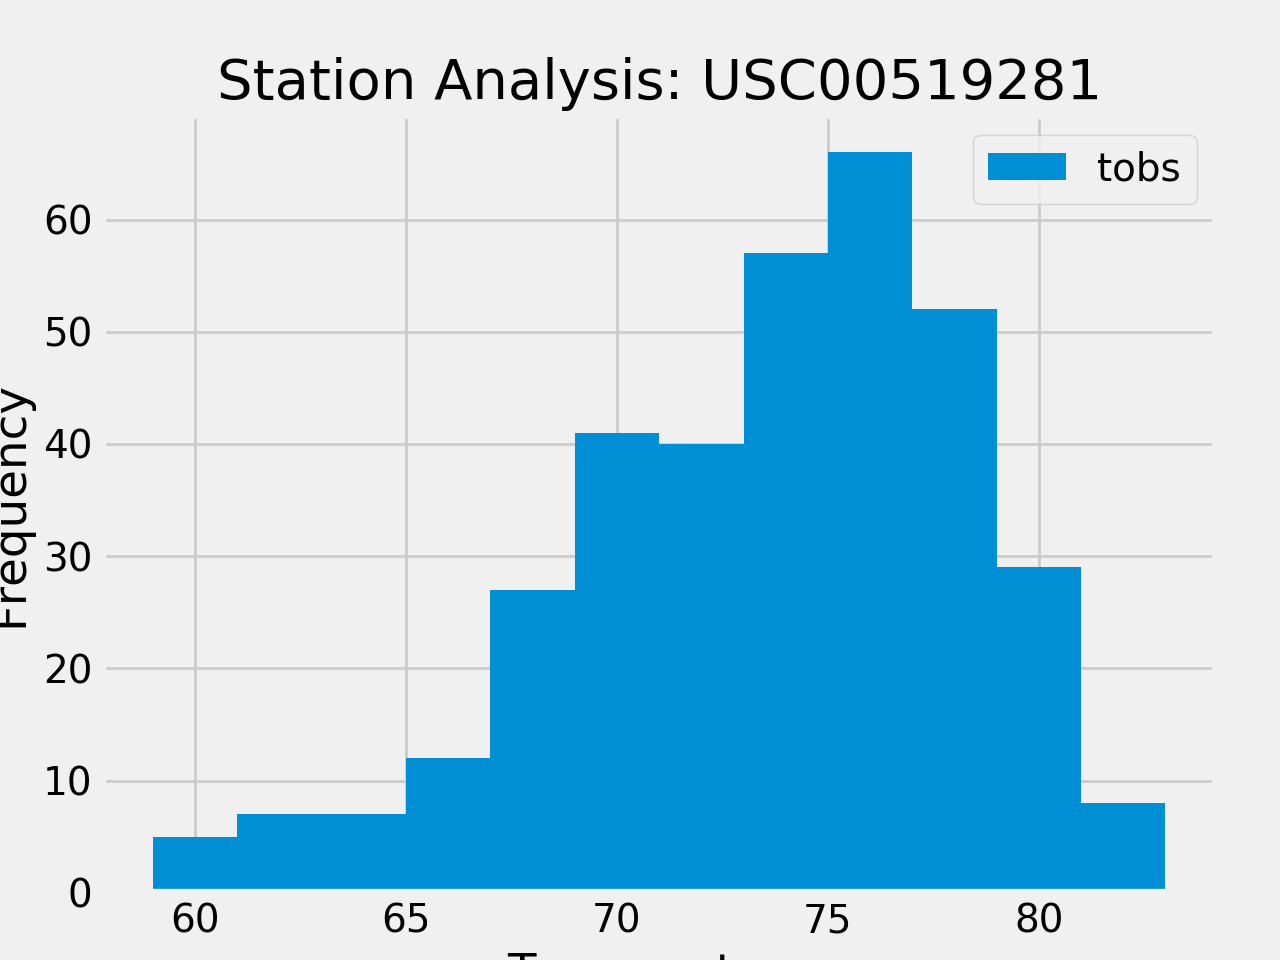

In [21]:
# Plot the results as a histogram with bins=12
DF_19281 = pd.DataFrame(tobs_19281)

plt.hist(DF_19281['tobs'],12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Station Analysis: USC00519281')
plt.legend(['tobs'])
plt.show()

# Temperature Analysis

In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# My trip date: From 1/16/2018 to 1/21/2018
Arrival = dt.date(2018, 1, 16)
Departure = dt.date(2018, 1, 21)

query_date_arrival = Arrival - dt.timedelta(days=365)
query_date_departure = Departure - dt.timedelta(days=365)

# error = [query_date_departure, query_date_arrival]

mytrip_calc_temps = calc_temps(query_date_arrival, query_date_departure)
mytrip_calc_temps


[(66.0, 71.94871794871794, 80.0)]

<IPython.core.display.Javascript object>


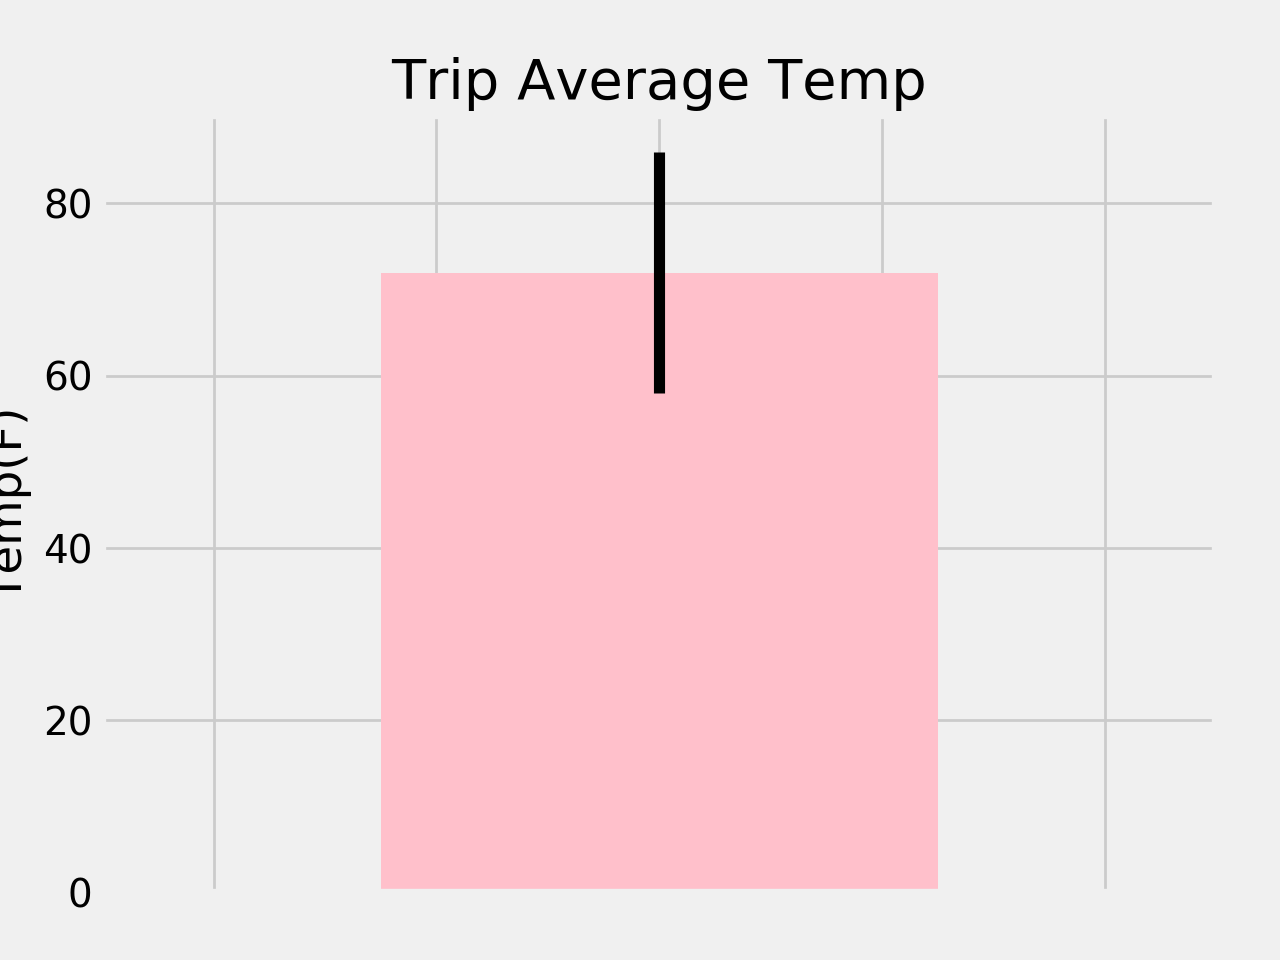

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [24]:
# Peak-to-peak (tmax-tmin) value as y error bar (yerr)
yerr = mytrip_calc_temps[0][2] - mytrip_calc_temps[0][0]

# Use the average temperature for the y value
y = mytrip_calc_temps[0][1]
x = 0

# Bar chart with Error Bar
fig, ax = plt.subplots()

# Use "Trip Avg Temp" as Title
ax.set_title("Trip Average Temp")
ax.set_ylabel("Temp(F)")

ax.bar(x, y, width=.05, color="pink", yerr=yerr)
ax.set_xlim(-.05, .05)
ax.tick_params(axis='x', labelbottom='off')
plt.show()

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation,\
        Measurement.prcp]

session.query(*sel).\
    filter(Measurement.date >= query_date_arrival).\
    filter(Measurement.date <= query_date_departure).\
    group_by(Station.name).\
    order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.08),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.08),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.08),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.08),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.08),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  0.08),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.08),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.08)]

## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
Jan16 = daily_normals("01-16")
Jan17 = daily_normals("01-17")
Jan18 = daily_normals("01-18")
Jan19 = daily_normals("01-19")
Jan20 = daily_normals("01-20")
Jan21 = daily_normals("01-21")
# push each tuple of calculations into a list called `normals`
normals=[Jan16, Jan17, Jan18, Jan19, Jan20, Jan21]

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
dates = ['01-16', '01-17', '01-18', '01-19', '01-20', '01-21']


In [28]:
tmin = [Jan16[0][0], Jan17[0][0], Jan18[0][0], Jan19[0][0], Jan20[0][0], Jan21[0][0]]
tavg = [Jan16[0][1], Jan17[0][1], Jan18[0][1], Jan19[0][1], Jan20[0][1], Jan21[0][1]]
tmax = [Jan16[0][2], Jan17[0][2], Jan18[0][2], Jan19[0][2], Jan20[0][2], Jan21[0][2]]

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
DF_normals = pd.DataFrame({'date':dates, 'tmin':tmin, 'tavg':tavg, 'tmax':tmax})
DF_normals.set_index('date', inplace=True)
DF_normals

,tmin,tavg,tmax
date,,,
01-16,54.0,68.629630,80.0
01-17,61.0,69.074074,76.0
01-18,57.0,68.631579,77.0
01-19,60.0,68.263158,78.0
01-20,61.0,68.866667,78.0
01-21,61.0,70.145455,76.0


<IPython.core.display.Javascript object>


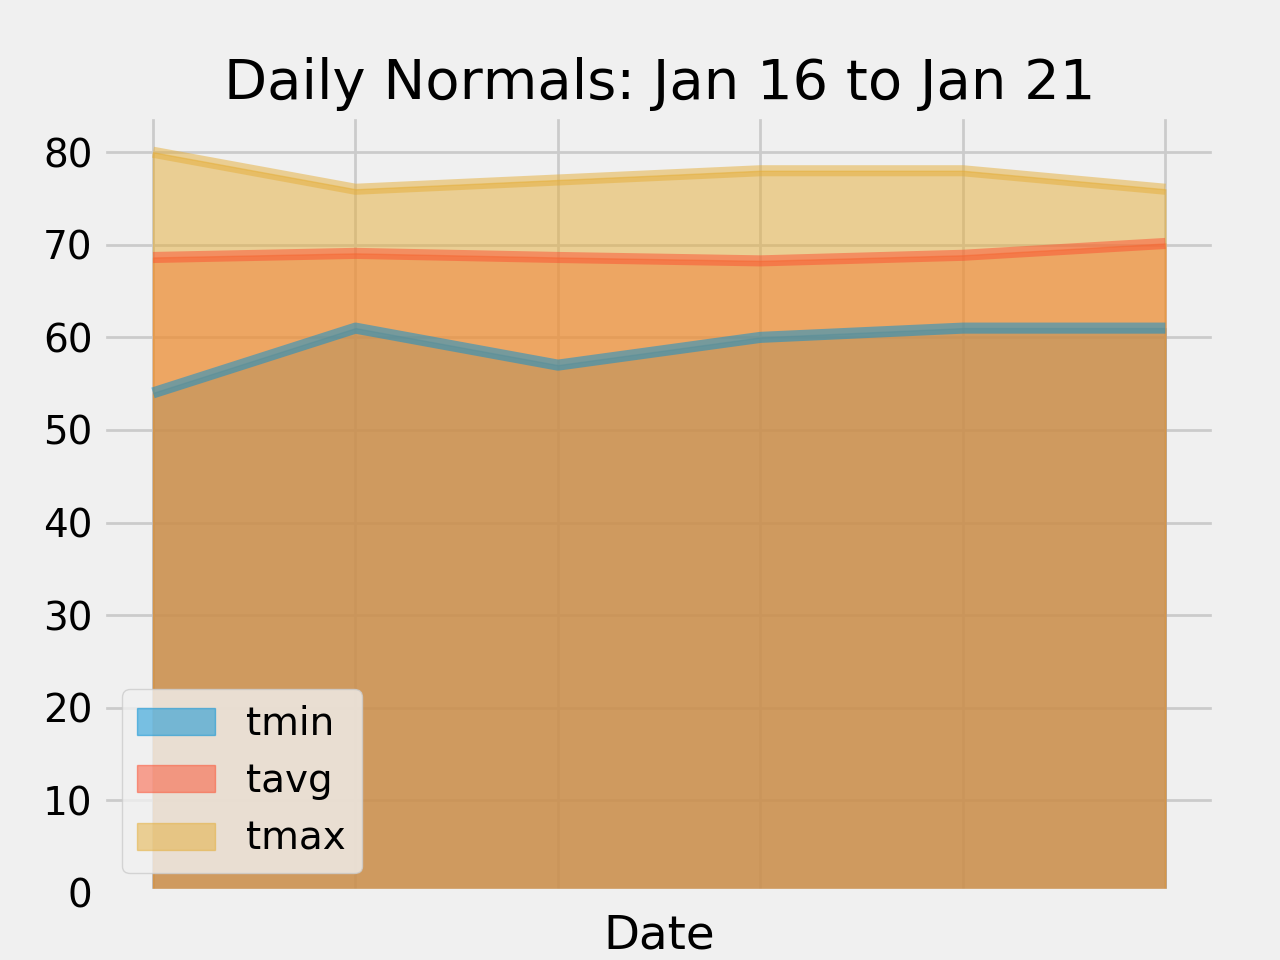

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
DF_normals.plot.area(stacked=False)
plt.title('Daily Normals: Jan 16 to Jan 21')
plt.xlabel('Date')
plt.show()